## **Libraries**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
class params:

    data_path = '/content/drive/MyDrive/Project'
    bad_images = '/content/drive/MyDrive/Project/Bad'
    good_images = '/content/drive/MyDrive/Project/Good'
    csv_files = '/content/drive/MyDrive/Project/csv_files'

In [3]:
import os
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

## **Dataset**



In [5]:
all_images = os.listdir(params.bad_images) + os.listdir(params.good_images)

In [7]:
dataset = pd.DataFrame(
    {
        'images': [f"{params.bad_images}/{x}" for x in os.listdir(params.bad_images)] + [f"{params.good_images}/{x}" for x in os.listdir(params.good_images)],
        'label': [0]*len(os.listdir(params.bad_images)) + [1]*len(os.listdir(params.good_images))
    }
)

In [8]:
dataset.head()

,images,label
0,/content/drive/MyDrive/Project/Bad/IMG_2024021...,0
1,/content/drive/MyDrive/Project/Bad/IMG_2024021...,0
2,/content/drive/MyDrive/Project/Bad/IMG_2024021...,0
3,/content/drive/MyDrive/Project/Bad/IMG_2024021...,0
4,/content/drive/MyDrive/Project/Bad/IMG_2024021...,0


In [20]:
dataset["label"] = dataset["label"].map({1: "Good Quality", 0: "Bad Quality"})

In [21]:
dataset['label'].value_counts(normalize = True)

label
Good Quality    0.773626
Bad Quality     0.226374
Name: proportion, dtype: float64

In [63]:
# Split the data into training and validation sets
train_valid_df, test_df = train_test_split(dataset, test_size=0.2, stratify=dataset['label'], random_state=42)
train_df, val_df = train_test_split(train_valid_df, test_size=0.2, stratify=train_valid_df['label'], random_state=42)

In [64]:
train_df.shape, val_df.shape, test_df.shape

((291, 2), (73, 2), (91, 2))

## **Reading CSV Files**

## **Exploratory Data Analysis**

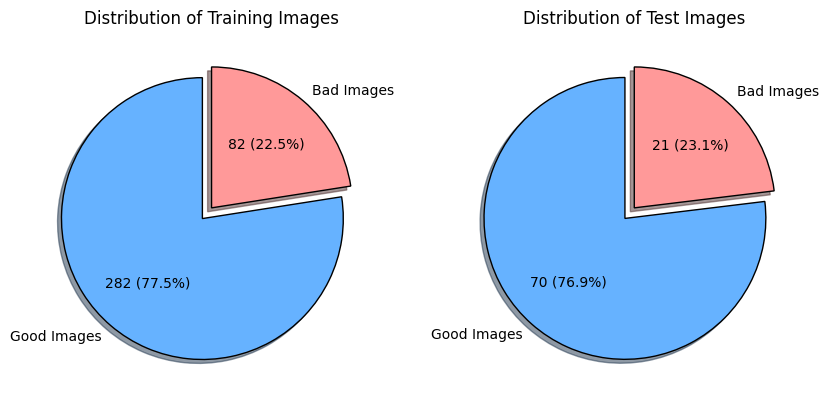

In [65]:
import matplotlib.pyplot as plt

# Sample data
labels = ['Good Images', 'Bad Images']
counts_train = [282, 82]  # Replace with your actual counts
counts_test = [70, 21]  # Replace with your actual counts

# Calculate percentages
total_count_train = sum(counts_train)
percentages_train = [(count / total_count_train) * 100 for count in counts_train]

total_count_test = sum(counts_test)
percentages_test = [(count / total_count_test) * 100 for count in counts_test]

# Define pleasing colors
colors = ['#66b2ff', '#ff9999']

# Plotting the 2D pie chart with shadow
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# Define the amount of explosion (0.1 means 10% of the radius)
explode = (0.1, 0)

ax[0].pie(counts_train, labels=labels, autopct=lambda p: '{:.0f} ({:.1f}%)'.format(p * total_count_train / 100, p),
          startangle=90, colors=colors, wedgeprops={'edgecolor': 'black'}, shadow=True, explode=explode)
# Add a title
ax[0].set_title('Distribution of Training Images')

ax[1].pie(counts_test, labels=labels, autopct=lambda p: '{:.0f} ({:.1f}%)'.format(p * total_count_test / 100, p),
          startangle=90, colors=colors, wedgeprops={'edgecolor': 'black'}, shadow=True, explode=explode)
# Add a title
ax[1].set_title('Distribution of Test Images')

# Display the 2D pie chart with shadow
plt.show()


## **Modeling**

In [66]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [67]:
train_df.head()

,images,label
110,/content/drive/MyDrive/Project/Good/IMG_202402...,Good Quality
162,/content/drive/MyDrive/Project/Good/IMG_202402...,Good Quality
312,/content/drive/MyDrive/Project/Good/IMG_202402...,Good Quality
446,/content/drive/MyDrive/Project/Good/IMG_202402...,Good Quality
353,/content/drive/MyDrive/Project/Good/IMG_202402...,Good Quality


In [75]:
# ImageDataGenerator for data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='images',
    y_col='label',
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='images',
    y_col='label',
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary'
)

Found 291 validated image filenames belonging to 2 classes.
Found 73 validated image filenames belonging to 2 classes.


In [76]:
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Activation, Dropout
from keras import backend
import tensorflow as tf
import keras

# Define image dimensions
DIMENSIONS = (256, 256)

# Creating simple model
def simple_model():
    # Clearing any model memory
    backend.clear_session()

    # Creating Sequential model
    model = Sequential()

    # Adding convolution layers
    model.add(Conv2D(32, (3, 3), kernel_initializer='he_uniform', activation="relu", input_shape=(*DIMENSIONS, 3)))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(64, (3, 3), kernel_initializer='he_uniform', activation="relu"))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(128, (3, 3), kernel_initializer='he_uniform', activation="relu"))
    model.add(MaxPooling2D(2, 2))

    # Flattening the output and adding Dense layers
    model.add(Flatten())
    model.add(Dense(512, activation="relu", kernel_initializer='he_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation="relu", kernel_initializer='he_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.summary()

    return model

# Instantiate the model
model = simple_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 128)       0

In [77]:
# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [78]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=10
)

Epoch 1/10
9/9 [==============================] - 235s 25s/step - loss: 13.1828 - accuracy: 0.6255 - val_loss: 0.8391 - val_accuracy: 0.7812
Epoch 2/10
9/9 [==============================] - 183s 20s/step - loss: 0.8824 - accuracy: 0.6873 - val_loss: 0.4489 - val_accuracy: 0.7812
Epoch 3/10
9/9 [==============================] - 190s 23s/step - loss: 0.4642 - accuracy: 0.7568 - val_loss: 0.3749 - val_accuracy: 0.7969
Epoch 4/10
9/9 [==============================] - 165s 18s/step - loss: 0.3531 - accuracy: 0.8147 - val_loss: 0.3547 - val_accuracy: 0.8594
Epoch 5/10
9/9 [==============================] - 166s 18s/step - loss: 0.3475 - accuracy: 0.8726 - val_loss: 0.3689 - val_accuracy: 0.8594
Epoch 6/10
9/9 [==============================] - 168s 19s/step - loss: 0.2905 - accuracy: 0.9073 - val_loss: 0.3205 - val_accuracy: 0.8750
Epoch 7/10
9/9 [==============================] - 165s 18s/step - loss: 0.3473 - accuracy: 0.8919 - val_loss: 0.2884 - val_accuracy: 0.9062
Epoch 8/10
9/9 [===

In [79]:
val_loss, val_accuracy = model.evaluate(val_generator, steps=val_generator.samples // val_generator.batch_size)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

2/2 [==============================] - 24s 12s/step - loss: 0.2913 - accuracy: 0.9062
Validation Loss: 0.291269451379776
Validation Accuracy: 0.90625


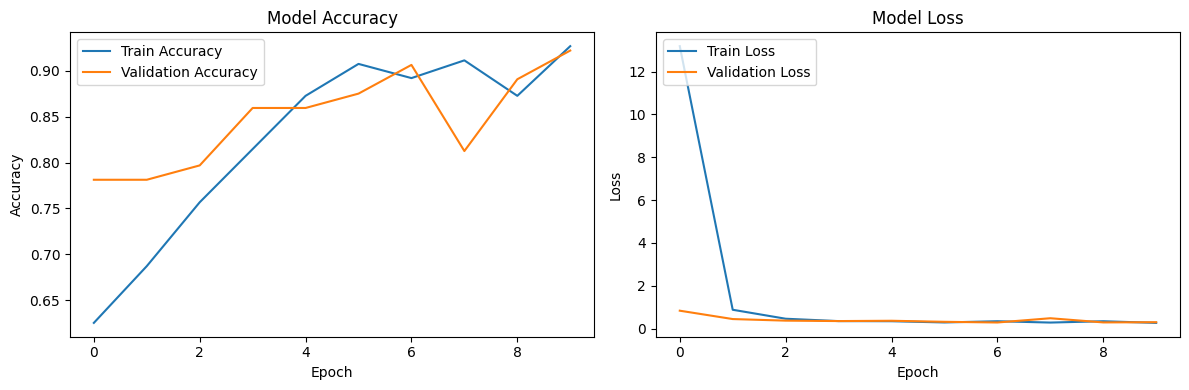

In [80]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Summarize history for accuracy
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')

    # Summarize history for loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)

In [81]:
import pandas as pd
from tensorflow.keras.preprocessing import image
import numpy as np

def load_and_preprocess_image(img_path, target_size=(256, 256)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def predict_on_new_images(model, new_df, target_size=(256, 256), threshold=0.5):
    # Load and preprocess the images
    new_images = np.vstack(new_df['images'].apply(lambda x: load_and_preprocess_image(x, target_size)))

    # Make predictions
    predictions = model.predict(new_images)

    # Apply threshold to get binary classification
    new_df['predictions'] = (predictions > threshold).astype(int)

    # Optionally map predictions to labels
    new_df['predicted_label'] = new_df['predictions'].map({0: 'Bad Quality', 1: 'Good Quality'})

    return new_df

In [82]:
new_df = predict_on_new_images(model, test_df, target_size=DIMENSIONS)

3/3 [==============================] - 5s 2s/step


In [83]:
new_df.head()

,images,label,predictions,predicted_label
168,/content/drive/MyDrive/Project/Good/IMG_202402...,Good Quality,1,Good Quality
93,/content/drive/MyDrive/Project/Bad/IMG_2024021...,Bad Quality,0,Bad Quality
292,/content/drive/MyDrive/Project/Good/IMG_202402...,Good Quality,1,Good Quality
183,/content/drive/MyDrive/Project/Good/IMG_202402...,Good Quality,1,Good Quality
345,/content/drive/MyDrive/Project/Good/IMG_202402...,Good Quality,1,Good Quality


## **Model Evaluation**

In [84]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [85]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

**Models Accuracy**

In [86]:
prediction = new_df["predicted_label"]
y_test = new_df["label"]

In [87]:
print(f"CNN Accuracy: {accuracy_score(y_test, prediction)}")

CNN Accuracy: 0.967032967032967


In [88]:
## Logistic Regression
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

 Bad Quality       1.00      0.86      0.92        21
Good Quality       0.96      1.00      0.98        70

    accuracy                           0.97        91
   macro avg       0.98      0.93      0.95        91
weighted avg       0.97      0.97      0.97        91



In [89]:
## Logistic Regression
confusion_matrix(y_test, prediction)

array([[18,  3],
       [ 0, 70]])

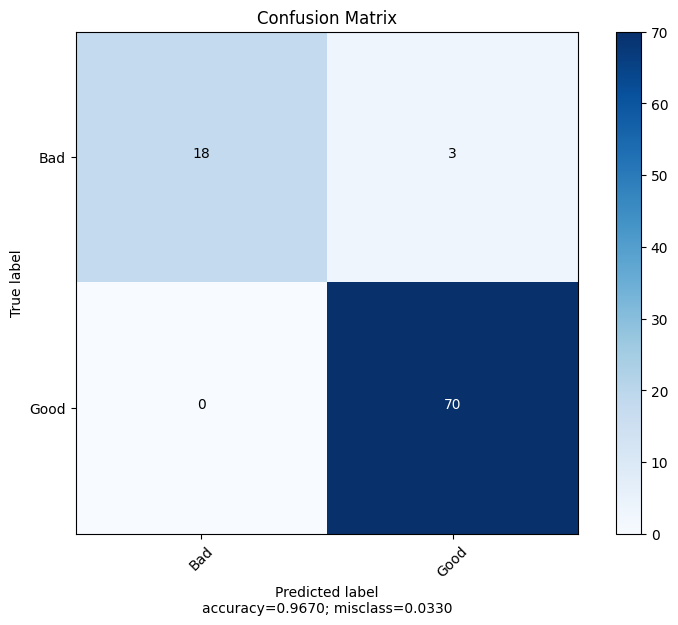

In [91]:
plot_confusion_matrix(cm           = confusion_matrix(y_test, prediction),
                      normalize    = False,
                      target_names = ['Bad', 'Good'],
                      title        = "Confusion Matrix")